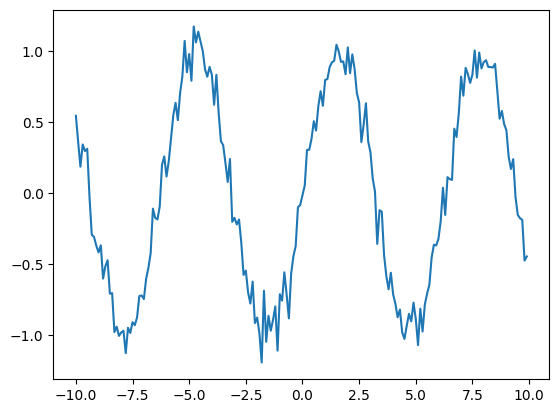

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x=np.arange(-10,10,0.1)
x = x.reshape(len(x),1)
y = np.sin(x)+0.1*np.random.randn(len(x),1)

plt.plot(x,y)
plt.show()


In [2]:
class RNN:
    def __init__(self,x,n_neurons):
        self.n_neurons = n_neurons
        self.x_t = x
        self.t = max(x.shape)
        self.y_hat = np.zeros((self.t,1))
        
        self.H = [np.zeros((self.n_neurons,1)) for _ in range(self.t+1)]

        self.Wx = 0.1*np.random.randn(self.n_neurons,1)
        self.Wh = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.Wy = 0.1*np.random.randn(1,self.n_neurons)
        self.bias = 0.1*np.random.randn(self.n_neurons,1)

    def forward(self,xt,ht_1):
        out = np.dot(self.Wx,xt)+np.dot(self.Wh,ht_1)+self.bias
        ht = np.tanh(out)
        y_hat_t = np.dot(self.Wy,ht)

        return ht , y_hat_t,out 

In [3]:
r=RNN(x,500)
ht=r.H[0]
# r.y_hat.shape
for t,xt in enumerate(x):
    xt = xt.reshape(1,1)
    ht,y_hat_t,out=r.forward(xt,ht)
    r.H[t+1]=ht
    r.y_hat[t]=y_hat_t


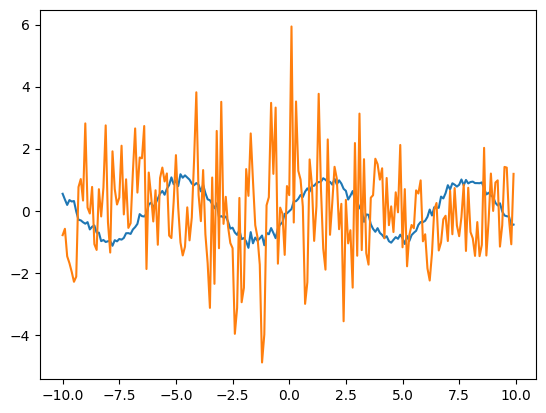

In [4]:
plt.plot(x,y)
plt.plot(x,r.y_hat)
plt.show()

/tmp/ipykernel_14254/2678916624.py:101: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'Loss : {float(L)} ')


Loss : 1.4401 
Loss : 0.3474 
Loss : 0.2632 
Loss : 0.2187 
Loss : 0.1888 
Loss : 0.1664 
Loss : 0.1488 
Loss : 0.1343 
Loss : 0.1222 
Loss : 0.112 


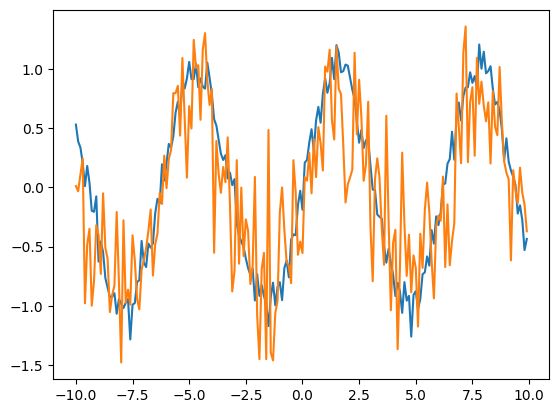

In [5]:
class Tanh:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.tanh(self.inputs)

    def backward(self,dvalues):
        der = 1-self.output**2
        self.dinputs = np.multiply(der,dvalues) 

class RNN:
    def __init__(self,x,n_neurons,Activation):
        self.n_neurons = n_neurons
        self.x_t = x
        self.t = max(x.shape)
        self.y_hat = np.zeros((self.t,1))
        
        self.H = [np.zeros((self.n_neurons,1)) for _ in range(self.t+1)]

        self.Wx = 0.1*np.random.randn(self.n_neurons,1)
        self.Wh = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.Wy = 0.1*np.random.randn(1,self.n_neurons)
        self.bias = 0.1*np.random.randn(self.n_neurons,1)

        self.Activation = Activation

    
    def forward(self):
        self.dWx = np.zeros((self.n_neurons,1))
        self.dWh = np.zeros((self.n_neurons,self.n_neurons))
        self.dWy = np.zeros((1,self.n_neurons))
        self.dbias = np.zeros((self.n_neurons,1))

        x_t = self.x_t
        H=self.H
        y_hat =self.y_hat
        ht = H[0]

        
        Act = [self.Activation for t in range(self.t)]

        [Act,H,y_hat]=self.RNN_cell(x_t,ht,Act,H,y_hat)

        self.y_hat = y_hat
        self.H = H
        self.Act = Act

    def RNN_cell(self,x_t,ht,Act,H,y_hat):

        for t,xt in enumerate(x_t):

            xt = xt.reshape(1,1)
            out = np.dot(self.Wx,xt)+np.dot(self.Wh,ht)+self.bias
            Act[t].forward(out)
            ht = Act[t].output
            y_hat_t = np.dot(self.Wy,ht)

            H[t+1]=ht
            y_hat[t]=y_hat_t

        return Act,H,y_hat
    
    def backward(self,dvalues):

        dht = np.dot(self.Wy.T,dvalues[-1].reshape(1,1))
        for t in reversed(range(self.t)):
            dy = dvalues[t].reshape(1,1)
            xt = self.x_t[t].reshape(1,1)

            self.Act[t].backward(dht)
            dtanh = self.Act[t].dinputs 

            
            self.dWy     += np.dot(self.H[t+1],dy).T
            self.dWx += np.dot(dtanh,xt)
            self.dWh += np.dot(dtanh,self.H[t].T)
            self.dbias += dtanh

            
            dht = np.dot(self.Wh, dtanh) + np.dot(self.Wy.T, dy)



import numpy as np
import matplotlib.pyplot as plt

x=np.arange(-10,10,0.1)
x = x.reshape(len(x),1)
y = np.sin(x)+0.1*np.random.randn(len(x),1)

r = RNN(x,500,Tanh())
for i in range(1000):
    r.forward()
    y_hat = r.y_hat
    t=r.t
    H=r.H

    dy = y_hat - y
    L = np.round(0.5*np.dot(dy.T,dy)/t,4)
    
    if i%100 == 0:
        print(f'Loss : {float(L)} ')

    r.backward(dy)
    r.Wh -= 1e-3*r.dWh
    r.Wx  -= 1e-3*r.dWx
    r.Wy -= 1e-5*r.dWy
    r.bias -= 1e-5*r.dbias
    
plt.plot(x,y)
plt.plot(x,y_hat)
plt.show()

In [6]:
class SGD_Optimizer:
    def __init__(self,learning_rate=1,decay=0,momentum=0):
        self.learning_rate = learning_rate
        self.current_learning_rate=learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iteration = 0
    
    def pre_update(self):
        if self.decay:
            self.current_learning_rate = (self.learning_rate)*(1.0/(1.+(self.decay*self.iteration)))

    def parameter_update(self,layer):
        if self.momentum:
            if not hasattr(layer,'momentum_weights'):
                layer.momentum_Wx = np.zeros_like(layer.Wx)
                layer.momentum_Wh = np.zeros_like(layer.Wh)
                layer.momentum_Wy = np.zeros_like(layer.Wy)
                layer.momentum_bias = np.zeros_like(layer.bias)
            
            weight_updates_Wx = self.momentum * layer.momentum_Wx - \
                             self.current_learning_rate * layer.dWx
            layer.momentum_Wx = weight_updates_Wx

            weight_updates_Wy = self.momentum * layer.momentum_Wy - \
                             self.current_learning_rate * layer.dWy
            layer.momentum_Wy = weight_updates_Wy

            weight_updates_Wh = self.momentum * layer.momentum_Wh - \
                             self.current_learning_rate * layer.dWh
            layer.momentum_Wh = weight_updates_Wh

            bias_updates = self.momentum * layer.momentum_bias - \
                           self.current_learning_rate * layer.dbias
            layer.momentum_bias = bias_updates
            
    
        else:
            weight_updates_Wx = -self.current_learning_rate*layer.dWx
            weight_updates_Wy = -self.current_learning_rate*layer.dWy
            weight_updates_Wh = -self.current_learning_rate*layer.dWh
            bias_updates = -self.current_learning_rate*layer.dbias
            
        layer.Wx += weight_updates_Wx
        layer.Wy += weight_updates_Wy
        layer.Wh += weight_updates_Wh
        layer.bias += bias_updates
        
    def post_update(self):
            self.iteration += 1

Loss : 2.2737 
Loss : 0.2992 
Loss : 0.2721 
Loss : 0.26 
Loss : 0.2525 
Loss : 0.2471 
Loss : 0.243 
Loss : 0.2398 
Loss : 0.2371 
Loss : 0.2348 
Loss : 0.2328 
Loss : 0.2311 
Loss : 0.2296 
Loss : 0.2282 
Loss : 0.227 
Loss : 0.2259 
Loss : 0.2249 
Loss : 0.224 
Loss : 0.2231 
Loss : 0.2223 
Loss : 0.2215 
Loss : 0.2208 
Loss : 0.2202 
Loss : 0.2196 
Loss : 0.219 
Loss : 0.2185 
Loss : 0.2179 
Loss : 0.2174 
Loss : 0.217 
Loss : 0.2165 
Loss : 0.2161 
Loss : 0.2157 
Loss : 0.2153 
Loss : 0.2149 
Loss : 0.2146 
Loss : 0.2142 
Loss : 0.2139 
Loss : 0.2136 
Loss : 0.2133 
Loss : 0.213 
Loss : 0.2127 
Loss : 0.2124 
Loss : 0.2121 
Loss : 0.2119 
Loss : 0.2116 
Loss : 0.2113 
Loss : 0.2111 
Loss : 0.2109 
Loss : 0.2106 
Loss : 0.2104 
Loss : 0.2102 
Loss : 0.21 
Loss : 0.2098 
Loss : 0.2096 
Loss : 0.2094 
Loss : 0.2092 
Loss : 0.209 
Loss : 0.2089 
Loss : 0.2087 
Loss : 0.2085 
Loss : 0.2083 
Loss : 0.2082 
Loss : 0.208 
Loss : 0.2079 
Loss : 0.2077 
Loss : 0.2075 
Loss : 0.2074 
Loss : 

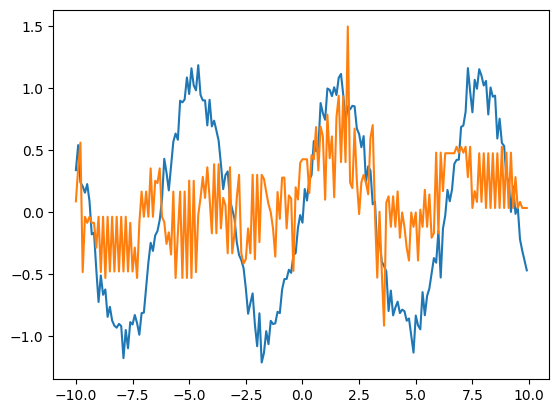

In [7]:
import numpy as np
import matplotlib.pyplot as plt


x=np.arange(-10,10,0.1)
x = x.reshape(len(x),1)
y = np.sin(x)+0.1*np.random.randn(len(x),1)

r = RNN(x,500,Tanh())
opt=SGD_Optimizer(1e-5,0.01,0.99)

for i in range(10000):
    r.forward()
    y_hat = r.y_hat
    t=r.t
    H=r.H

    dy = y_hat - y
    L = np.round(0.5*np.dot(dy.T,dy)/t,4)
    
    if i%100 == 0:
        print(f'Loss : {L[0][0]} ')

    r.backward(dy)
    opt.pre_update()
    opt.parameter_update(r)
    opt.post_update()

plt.plot(x,y)
plt.plot(x,y_hat)
plt.show()